# Example 1: Symbolic Regressor

In [1]:
%pylab inline
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import pydotplus

Populating the interactive namespace from numpy and matplotlib


/home/trev/.virtualenvs/ve/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


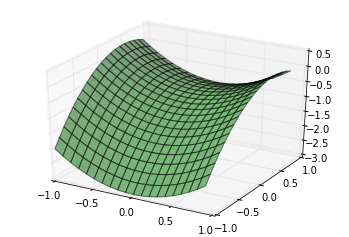

In [2]:
# Ground truth
x0 = np.arange(-1, 1, 1/10.)
x1 = np.arange(-1, 1, 1/10.)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**2 - x1**2 + x1 - 1

ax = plt.figure().gca(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1, color='green', alpha=0.5)
plt.show()

In [3]:
rng = check_random_state(0)

# Training samples
X_train = rng.uniform(-1, 1, 100).reshape(50, 2)
y_train = X_train[:, 0]**2 - X_train[:, 1]**2 + X_train[:, 1] - 1

# Testing samples
X_test = rng.uniform(-1, 1, 100).reshape(50, 2)
y_test = X_test[:, 0]**2 - X_test[:, 1]**2 + X_test[:, 1] - 1

In [4]:
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train, y_train)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13     458.57768152        5   0.320665972828   0.556763539274      1.28m
   1     9.97    1.70232723129        5   0.320201761523   0.624787148042     57.78s
   2     7.72    1.94456344674       11   0.239536660154   0.533148180489     46.35s
   3     5.41   0.990156815469        7   0.235676349446   0.719906258051     37.93s
   4     4.66   0.894443363616       11   0.103946413589   0.103946413589     32.20s
   5     5.41   0.940242380405       11  0.0608020404276  0.0608020404276     28.15s
   6     6.78     1.0953592564       11 0.000781474035346 0.000781474035346     24.85s


SymbolicRegressor(const_range=(-1.0, 1.0),
         function_set=('add', 'sub', 'mul', 'div'), generations=20,
         init_depth=(2, 6), init_method='half and half', max_samples=0.9,
         metric='mean absolute error', n_jobs=1, p_crossover=0.7,
         p_hoist_mutation=0.05, p_point_mutation=0.1, p_point_replace=0.05,
         p_subtree_mutation=0.1, parsimony_coefficient=0.01,
         population_size=5000, random_state=0, stopping_criteria=0.01,
         tournament_size=20, verbose=1, warm_start=False)

In [5]:
print est_gp._program

sub(add(-0.999, X1), mul(sub(X1, X0), add(X0, X1)))


In [6]:
est_tree = DecisionTreeRegressor()
est_tree.fit(X_train, y_train)
est_rf = RandomForestRegressor()
est_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

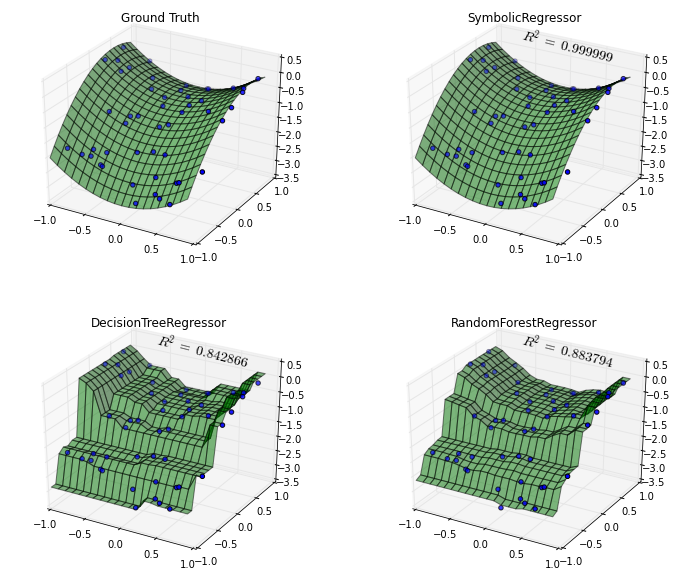

In [7]:
y_gp = est_gp.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_gp = est_gp.score(X_test, y_test)
y_tree = est_tree.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_tree = est_tree.score(X_test, y_test)
y_rf = est_rf.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_rf = est_rf.score(X_test, y_test)

fig = plt.figure(figsize=(12, 10))

for i, (y, score, title) in enumerate([(y_truth, None, "Ground Truth"),
                                       (y_gp, score_gp, "SymbolicRegressor"),
                                       (y_tree, score_tree, "DecisionTreeRegressor"),
                                       (y_rf, score_rf, "RandomForestRegressor")]):

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    surf = ax.plot_surface(x0, x1, y, rstride=1, cstride=1, color='green', alpha=0.5)
    points = ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
    if score is not None:
        score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=14)
    plt.title(title)

plt.show()

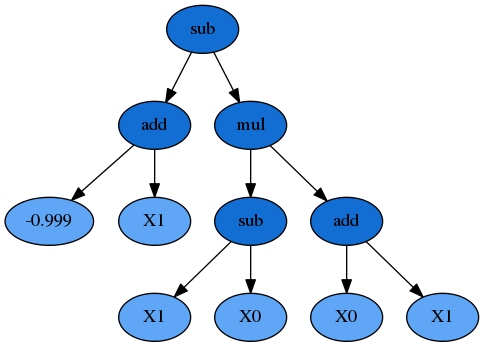

In [8]:
graph = pydotplus.graphviz.graph_from_dot_data(est_gp._program.export_graphviz())
Image(graph.create_png())

In [9]:
print est_gp._program.parents

{'donor_nodes': [], 'parent_idx': 1555, 'parent_nodes': [1, 2, 3], 'method': 'Crossover', 'donor_idx': 78}


add(-0.999, X1)
Fitness: 0.351803319075


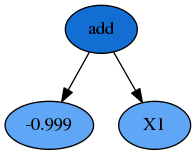

In [10]:
idx = est_gp._program.parents['donor_idx']
fade_nodes = est_gp._program.parents['donor_nodes']
print est_gp._programs[-2][idx]
print 'Fitness:', est_gp._programs[-2][idx].fitness_
graph = est_gp._programs[-2][idx].export_graphviz(fade_nodes=fade_nodes)
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())

sub(sub(X1, 0.939), mul(sub(X1, X0), add(X0, X1)))
Fitness: 0.170802040428


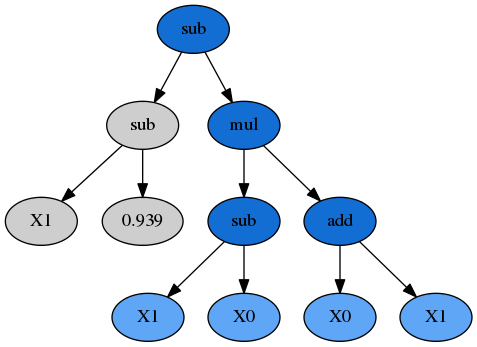

In [11]:
idx = est_gp._program.parents['parent_idx']
fade_nodes = est_gp._program.parents['parent_nodes']
print est_gp._programs[-2][idx]
print 'Fitness:', est_gp._programs[-2][idx].fitness_
graph = est_gp._programs[-2][idx].export_graphviz(fade_nodes=fade_nodes)
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())

# Example 2: Symbolic Transformer

In [12]:
from gplearn.genetic import SymbolicTransformer
from sklearn.utils import check_random_state
from sklearn.datasets import load_boston
import numpy as np

In [13]:
rng = check_random_state(0)
boston = load_boston()
perm = rng.permutation(boston.target.size)
boston.data = boston.data[perm]
boston.target = boston.target[perm]

In [14]:
from sklearn.linear_model import Ridge
est = Ridge()
est.fit(boston.data[:300, :], boston.target[:300])
print est.score(boston.data[300:, :], boston.target[300:])

0.759145222183


In [15]:
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min']
gp = SymbolicTransformer(generations=20, population_size=2000,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0, n_jobs=3)
gp.fit(boston.data[:300, :], boston.target[:300])

gp_features = gp.transform(boston.data)
new_boston = np.hstack((boston.data, gp_features))

est = Ridge()
est.fit(new_boston[:300, :], boston.target[:300])
print
print est.score(new_boston[300:, :], boston.target[300:])

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.04   0.339563945232        6   0.822502090604   0.675124281718     15.45s
   1      6.9   0.593571514052        7   0.836993346084    0.60246769713     26.45s
   2     5.07   0.730086823063        8   0.840630478099   0.704016759154     31.04s
   3     5.22   0.735522336355        5   0.847019340048   0.628350972062     31.17s
   4     6.24   0.734664772885       10   0.856612110958   0.565138160961     30.17s
   5     8.23    0.72142355296       18   0.856770174699   0.728095168863     29.32s
   6     10.2   0.717927252636       14   0.875232964962    0.61969315318     28.95s
   7    11.84   0.720663034418       14   0.875927001587   0.609363312042     28.26s
   8    12.56   0.733016826574       27    0.88170491049   0.390121268509  

# Example 3: Customizing your programs

In [16]:
from gplearn.functions import make_function

In [17]:
def logic(x1, x2, x3, x4):
    return np.where(x1 > x2, x3, x4)

logical = make_function(function=logic,
                        name='logical',
                        arity=4)

In [18]:
function_set = ['add', 'sub', 'mul', 'div', logical]
gp = SymbolicTransformer(generations=2, population_size=2000,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0, n_jobs=3)

In [19]:
gp.fit(boston.data[:300, :], boston.target[:300])

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    55.28   0.296205545754        3   0.792392994099    0.83171539208      1.01s
   1    10.35    0.53289333499        3   0.812058995784   0.673757538675      0.00s


SymbolicTransformer(const_range=(-1.0, 1.0),
          function_set=['add', 'sub', 'mul', 'div', <gplearn.functions._Function object at 0x7f43d5870110>],
          generations=2, hall_of_fame=100, init_depth=(2, 6),
          init_method='half and half', max_samples=0.9, metric='pearson',
          n_components=10, n_jobs=3, p_crossover=0.9,
          p_hoist_mutation=0.01, p_point_mutation=0.01,
          p_point_replace=0.05, p_subtree_mutation=0.01,
          parsimony_coefficient=0.0005, population_size=2000,
          random_state=0, stopping_criteria=1.0, tournament_size=20,
          verbose=1, warm_start=False)

In [20]:
print gp._programs[0][906]

sub(logical(X6, add(X11, 0.898), X10, X2), X5)


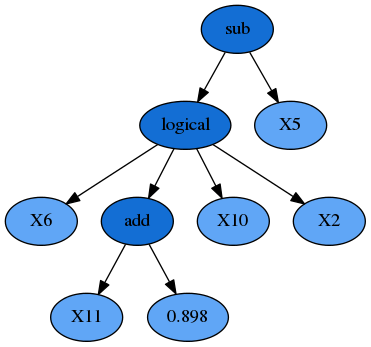

In [21]:
graph = gp._programs[0][906].export_graphviz()
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())